**5243 Project 3 Team 3**

In [ ]:
# Import required packages
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras import models, layers, losses
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import Loss
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
import time

#### Download

In [ ]:
!unzip data.zip

## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`.

In [2]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('data/noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset.

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


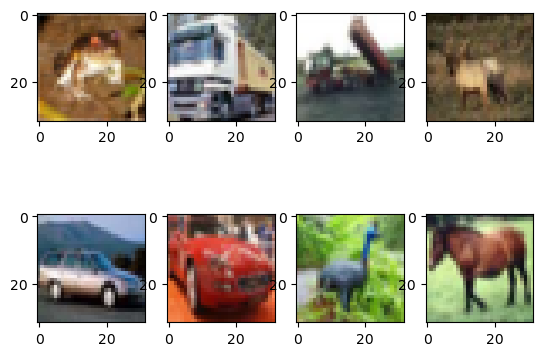

In [3]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))

## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [4]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [5]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [6]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

### 2.2. Model I

In [7]:
# [BUILD A MORE SOPHISTICATED PREDICTIVE MODEL]

def create_cnn_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

cnn_model = create_cnn_model()

/Users/helena/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [8]:
noisy_labels_one_hot = to_categorical(noisy_labels, num_classes=10)

imgs_normalized = imgs / 255.0

In [9]:
# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(imgs_normalized, noisy_labels_one_hot, test_size=0.2, random_state=42)

# Create an instance of ImageDataGenerator with desired augmentations
datagen = ImageDataGenerator(
    rotation_range=20,       # randomly rotate images to some degree
    width_shift_range=0.2,   # randomly shift images horizontally 
    height_shift_range=0.2,  # randomly shift images vertically
    horizontal_flip=True,    # randomly flip images horizontally
    zoom_range=0.2,          # randomly zoom image
)

datagen.fit(X_train)

In [10]:
# Calculate class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(noisy_labels),
    y=noisy_labels.flatten()
)
class_weights_dict = dict(enumerate(class_weights))

In [11]:
# Fit the model
history_cnn = cnn_model.fit(X_train, y_train, 
                            batch_size=64,
                            epochs=10,
                            validation_data=(X_val, y_val),
                            class_weight=class_weights_dict
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.1255 - loss: 2.2885 - val_accuracy: 0.1807 - val_loss: 2.2523
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.1860 - loss: 2.2414 - val_accuracy: 0.2062 - val_loss: 2.2310
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.2114 - loss: 2.2178 - val_accuracy: 0.2191 - val_loss: 2.2237
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.2223 - loss: 2.2047 - val_accuracy: 0.2172 - val_loss: 2.2222
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.2380 - loss: 2.1828 - val_accuracy: 0.2298 - val_loss: 2.2129
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.2508 - loss: 2.1557 - val_accuracy: 0.2304 - val_loss: 2.2139
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.2628 - loss: 2.1322 - val_accuracy: 0.2337 - val_loss: 2.2136
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.2751 - loss: 2.1090 - 

In [12]:
def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    image = image / 255.0
    image = np.expand_dims(image, axis=0)  # Expanding the dimensions to fit the model input
    predictions = cnn_model.predict(image)
    return np.argmax(predictions)  # Return the index of the highest probability class

### 2.3. Model II

In [13]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]

# use Noise-Robust Loss function to cnn model
class SymmetricCrossEntropy(Loss):
    def __init__(self, alpha=1.0, beta=2.0, from_logits=False):
        super(SymmetricCrossEntropy, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=self.from_logits)
        rce = tf.keras.losses.categorical_crossentropy(y_pred, y_true, from_logits=self.from_logits)
        return self.alpha * ce + self.beta * rce

def new_cnn_model_with():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        layers.Conv2D(48, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        layers.Conv2D(48, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(48, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss=SymmetricCrossEntropy(alpha=1.0, beta=2.0), # apply loss
                  metrics=['accuracy'])
    return model

new_cnn_model = new_cnn_model_with()

/Users/helena/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [14]:
clean_images = imgs[:n_clean_noisy]
clean_images_normalized = clean_images / 255.0 # normalize the clean images

# convert cleaned label to one hot encoding
clean_labels_one_hot = to_categorical(clean_labels, num_classes=10)

In [15]:
# predictions for the entire dataset
predictions = new_cnn_model.predict(imgs_normalized)

# select high-confidence predictions
confidence_threshold = 0.9
high_confidence_indices = np.max(predictions, axis=1) > confidence_threshold
high_confidence_images = imgs_normalized[high_confidence_indices]
high_confidence_labels = predictions[high_confidence_indices]

# convert high-confidence predictions to one-hot labels for training
high_confidence_labels_one_hot = np.zeros_like(high_confidence_labels)
high_confidence_labels_one_hot[np.arange(len(high_confidence_labels)), high_confidence_labels.argmax(1)] = 1

# combine high-confidence pseudo-labeled data with clean labeled data
combined_images = np.concatenate((clean_images_normalized, high_confidence_images), axis=0)
combined_labels_one_hot = np.concatenate((clean_labels_one_hot, high_confidence_labels_one_hot), axis=0)

# retrain the model on the combined dataset
history_retrain = new_cnn_model.fit(combined_images, combined_labels_one_hot, 
                                batch_size=64,
                                epochs=20,
                                validation_split=0.2,
                                class_weight=class_weights_dict)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.2134 - loss: 29.0649 - val_accuracy: 0.1120 - val_loss: 31.3582
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.3957 - loss: 23.3095 - val_accuracy: 0.1890 - val_loss: 29.8044
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.4535 - loss: 20.9068 - val_accuracy: 0.2480 - val_loss: 27.7968
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5051 - loss: 19.2905 - val_accuracy: 0.4325 - val_loss: 21.5436
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5165 - loss: 18.6363 - val_accuracy: 0.4890 - val_loss: 19.7533
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5583 - loss: 17.2214 - val_accuracy: 0.4675 - val_loss: 20.0291
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5808 - loss: 16.3474 - val_accuracy: 0.5265 - val_loss: 18.2898
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 

In [16]:
def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    predictions = new_cnn_model.predict(image)
    return np.argmax(predictions)

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose.

In [17]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [ ]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

In [18]:
test_imgs = imgs[0:1000]
test_labels = clean_labels[:1000]

The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.

In [19]:
# Accuracy of baseline model
start_time = time.time()
evaluation(baseline_model, test_labels, test_imgs)
end_time = time.time()

base_time = end_time - start_time
print("Baseline model evaluation time: {} seconds".format(base_time))

              precision    recall  f1-score   support

           0       0.32      0.45      0.37       102
           1       0.18      0.25      0.21       112
           2       0.24      0.05      0.08        99
           3       0.23      0.15      0.18        92
           4       0.26      0.52      0.34        99
           5       0.18      0.12      0.14        85
           6       0.28      0.36      0.31       107
           7       0.55      0.06      0.11       102
           8       0.27      0.44      0.34        99
           9       0.23      0.12      0.15       103

    accuracy                           0.25      1000
   macro avg       0.27      0.25      0.22      1000
weighted avg       0.27      0.25      0.23      1000

Baseline model evaluation time: 0.19481778144836426 seconds


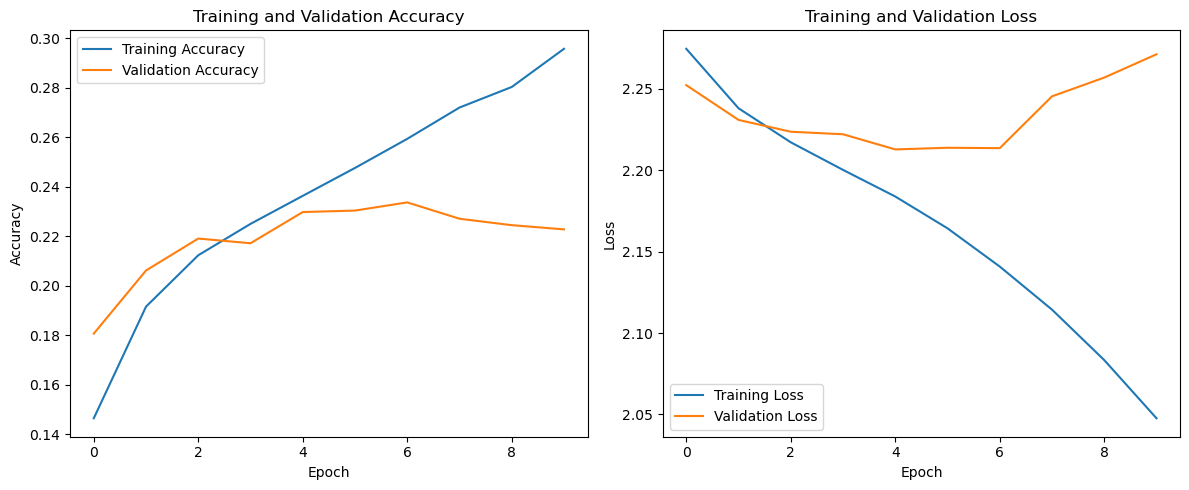

In [20]:
# Accuracy and Loss graph for Model I
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
# Evaluation time for Model I
start_time = time.time()
evaluation(model_I, test_labels, test_imgs)
end_time = time.time()

model1_time = end_time - start_time
print("Model I evaluation time: {} seconds".format(model1_time))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9

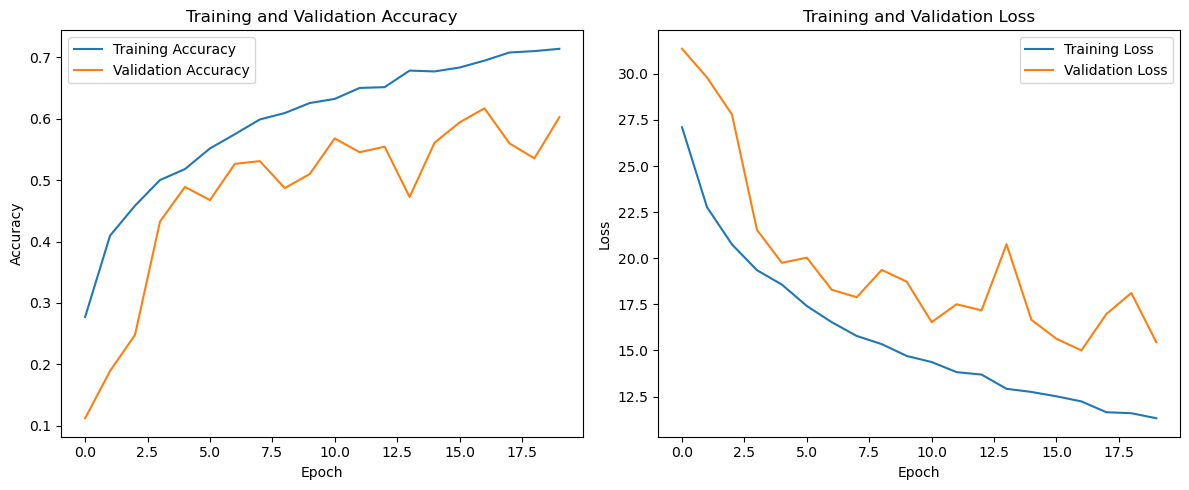

In [22]:
# Accuracy and Loss graph for Model II
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_retrain.history['accuracy'], label='Training Accuracy')
plt.plot(history_retrain.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_retrain.history['loss'], label='Training Loss')
plt.plot(history_retrain.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
# Evaluation time for Model II
start_time = time.time()
evaluation(model_II, test_labels, test_imgs)
end_time = time.time()

model2_time = end_time - start_time
print("Model II evaluation time: {} seconds".format(model2_time))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━

In [24]:
# Output label predicted by three models
label = test_labels[1:]
baseline = []
for image in test_imgs:
    baseline.append(baseline_model(image))
modelI = np.argmax(cnn_model.predict(test_imgs,verbose=0),1)
modelII = np.argmax(new_cnn_model.predict(test_imgs,verbose=0),1)

label_prediction = pd.DataFrame(zip(label, baseline, modelI ,modelII),
                                columns = ['Index','Baseline','Model I','Model II'])
label_prediction.to_csv('label_prediction.csv', index=False)